# House Prices - Advanced Regression Techniques
---

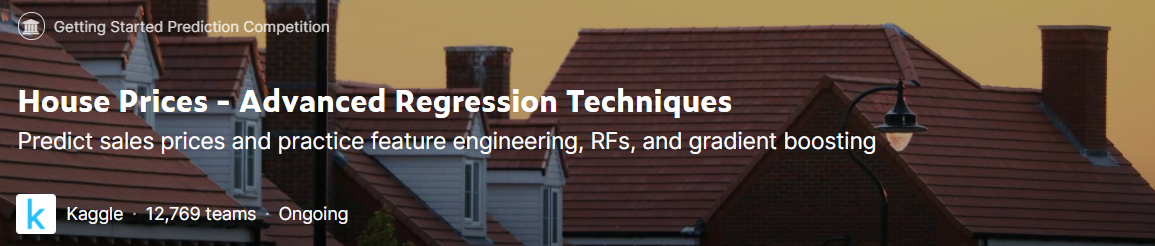

# Data Load
---

In [27]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

house_df_org = pd.read_csv('../data/houseprices/train.csv')
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [28]:
# 데이터 정보 확인
print('shape :',house_df.shape)
print('\n전체 피처의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 건수:\n',isnull_series[isnull_series > 0].sort_values(ascending=False))

shape : (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


# Data Preprocessing
---

<AxesSubplot:title={'center':'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

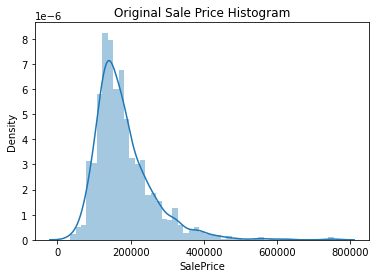

In [29]:
# target 분포 확인

plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

target 데이터인 SalePrice가 정규분포에서 벗어난 분포를 가진 것을 확인

따라서 로그 변환을 적용

<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

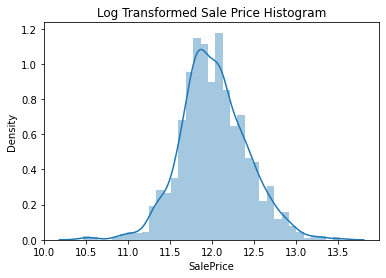

In [30]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [31]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# 데이터 양에 비해 결측치가 너무 많은 컬럼과 불필요한 컬럼 제거
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않는 숫자형 Null 컬럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명, 타입 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


문자형 피처를 제외하고 모든 Null 값이 채워진 것을 확인

따라서 위 피처는 원-핫 인코딩 진행

In [34]:
print('get_dummies() 수행 전 데이터 Shape :',house_df.shape)

house_df_ohe = pd.get_dummies(house_df)

print('get_dummies() 수행 후 데이터 Shape :',house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape : (1460, 75)
get_dummies() 수행 후 데이터 Shape : (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


# 모델 생성
---

In [37]:
# 여러 모델의 RMSE를 측정하는 함수 정의

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE: ', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]

get_rmses(models)

LinearRegression 로그 변환된 RMSE:  0.132
Ridge 로그 변환된 RMSE:  0.128
Lasso 로그 변환된 RMSE:  0.176


[0.13189576579154233, 0.1275084633405304, 0.17628250556471403]

위 세개 모델 중 Lasso 회귀에서 성능이 낮은 것을 확인.


따라서 하이퍼 파라미터 튜닝을 통해 추후 최적화 진행

**먼저 각 모델의 상위 10, 하위 10개 회귀 계수 확인**

In [39]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, -하위 10개 회귀 계수 추출
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

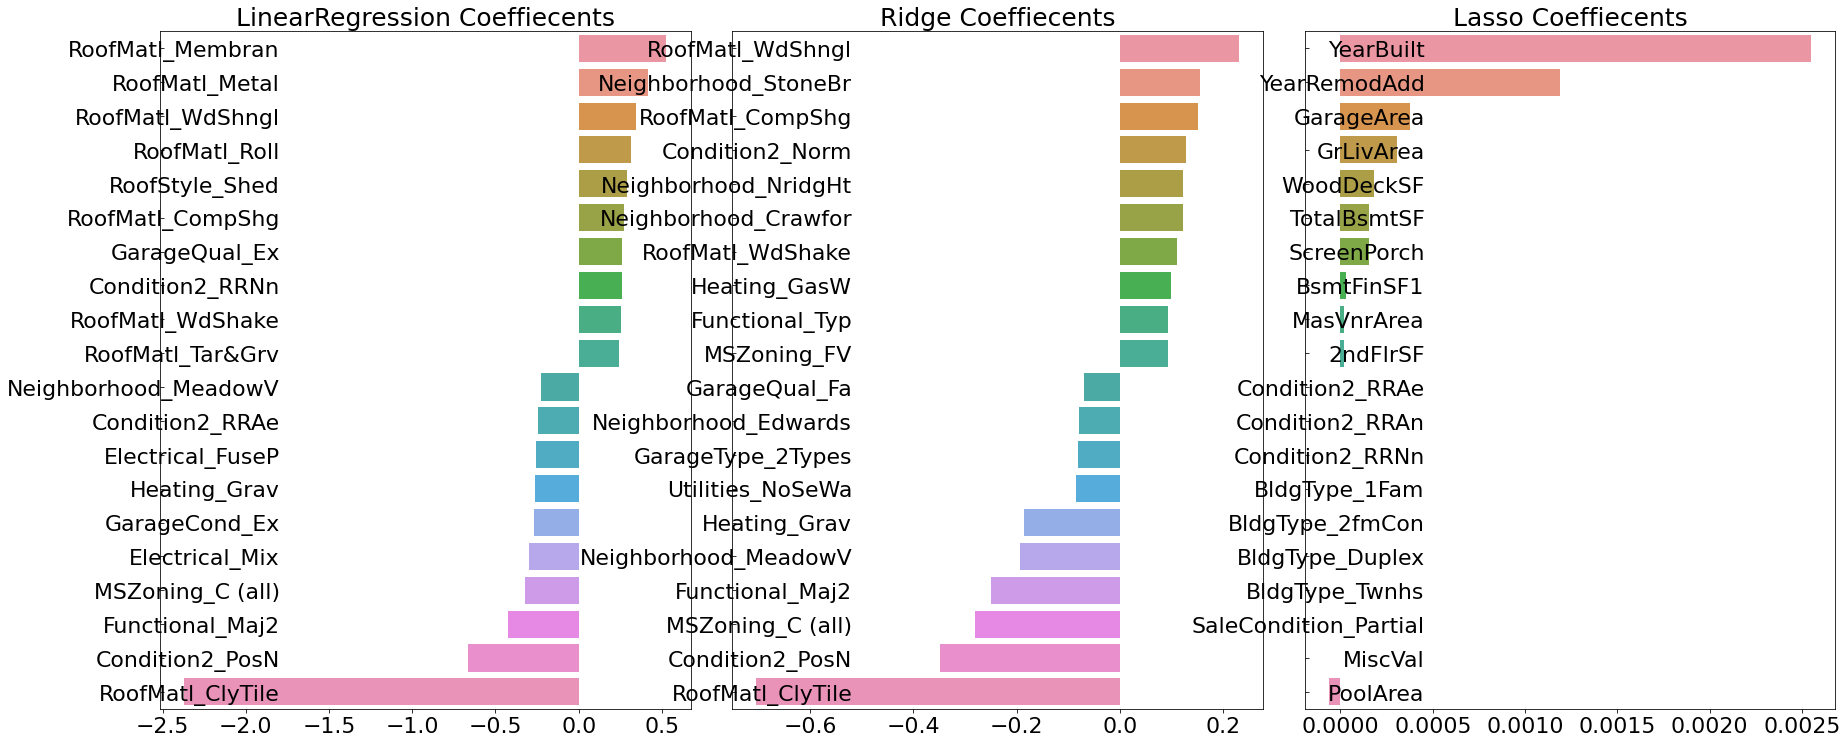

In [42]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplots 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수 구하고 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick labl 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis='y', direction = 'in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

위 시각화 결과 OLS 기반 LinearRegression과 RIdge의 경우 회귀계수가 유사하게 분포, Lasso의 경우 전체적인 회귀 계수가 매우 작고 YearBuilt 의 회귀 계수가 가장 높음

따라서 학습 데이터 분할에 문제가 있을 수 있어 전체 데이터를 5개 폴드로 나누어 RMSE를 측정

In [46]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
    
        print('\n{} CV RMSE 값 리스트 : {}'.format(model.__class__.__name__,np.round(rmse_list, 3)))
        print('{} CV 평균 RMSE 값 : {}'.format(model.__class__.__name__,np.round(rmse_avg, 3)))
    
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트 : [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값 : 0.155

Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값 : 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값 : 0.198


5 폴드로 나누어 학습을 진행해도 Lasso 모델의 성능이 제일 좋지 못한 것을 확인, 따라서 하이퍼 파라미터 튜닝을 통한 모델 최적화 진행

In [53]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params,
                             scoring = 'neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{} 5 CV 시 최적 평균 RMSE 값 : {}, 최적 alpha : {}'.format(model.__class__.__name__,
                                                             np.round(rmse, 4),
                                                             grid_model.best_params_))
    
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha : {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha : {'alpha': 0.001}


하이퍼파라미터 수행 시 Lasso 모델의 RMSE가 이상적으로 줄어듬

위 튜닝 결과를 토대로 모델을 재생성, 학습 후 평가를 진행


LinearRegression CV RMSE 값 리스트 : [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값 : 0.155

Ridge CV RMSE 값 리스트 : [0.115 0.148 0.13  0.118 0.186]
Ridge CV 평균 RMSE 값 : 0.139

Lasso CV RMSE 값 리스트 : [0.11  0.15  0.125 0.114 0.193]
Lasso CV 평균 RMSE 값 : 0.139


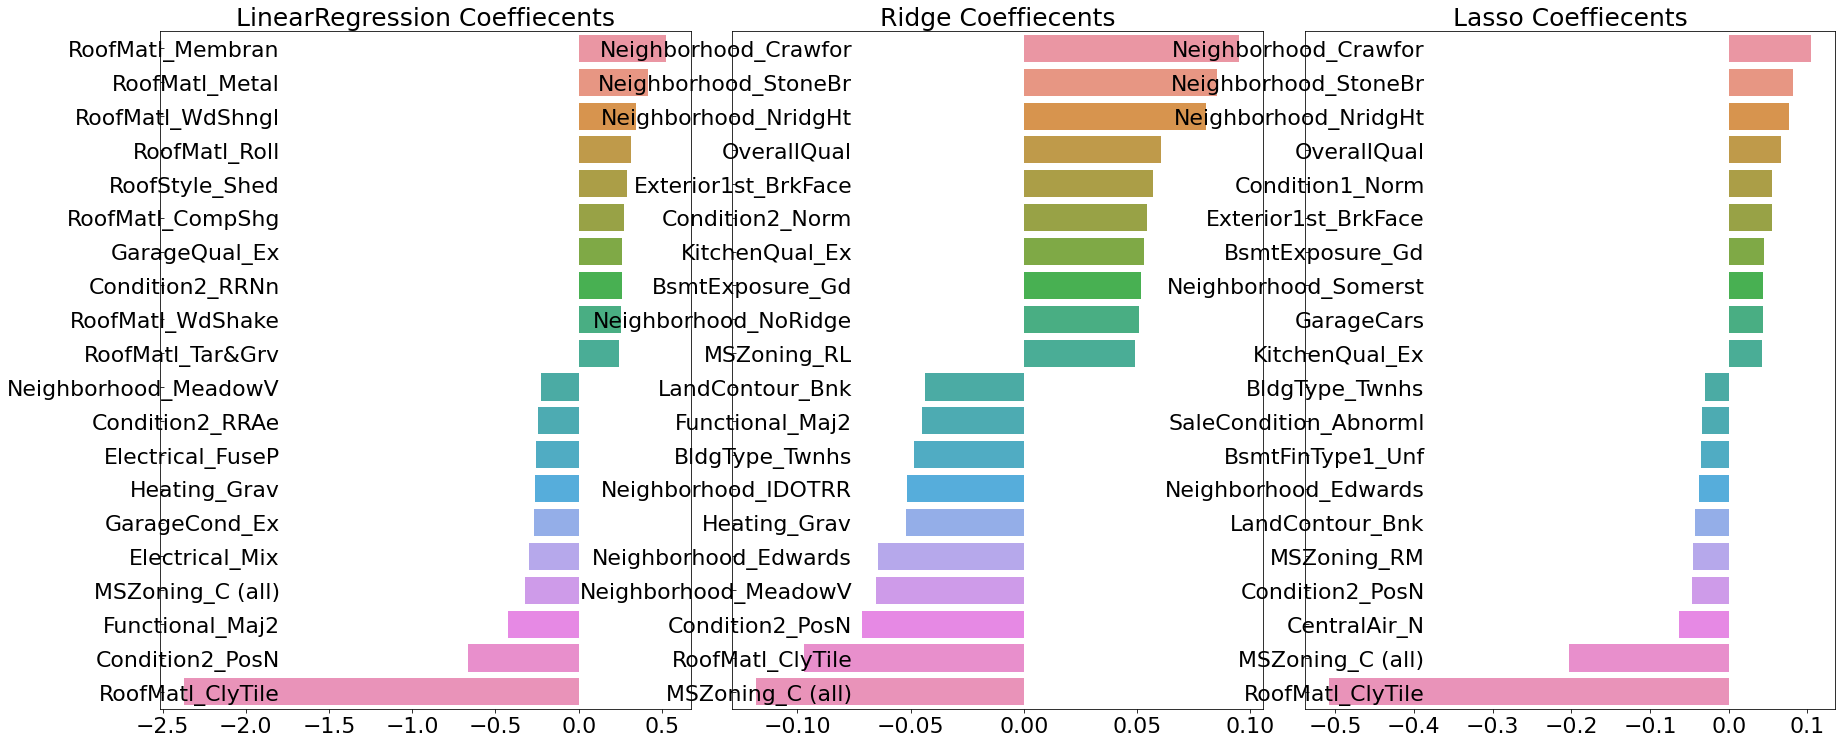

In [57]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)
get_avg_rmse_cv(models)

alpha 값 최적화 이후 전체적인 성능과 회귀 계수의 변화를 확인

이번엔 Ridge 모델에서 다른 모델에 비해 회귀 계수가 상대적으로 작은 것을 확인

추가적인 데이터 세트 가공 진행
 
skew() 함수를 이용해 데이터 세트의 왜곡된 정도를 확인, 일반적으로 1 이상이 경우를 왜곡 정도가 높다고 판단.

왜곡 정도가 1 이상인 데이터에 대해 로그 변환 진행

In [60]:
# Outlier 확인

from scipy.stats import skew

# ojbect가 아닌 숫자형 피처의 칼럼 index 객체 추출
feature_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환 apply lmabda 로 skew() 호출
skew_features = house_df[feature_index].apply(lambda x: skew(x))

# skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [63]:
# 왜곡 정도가 1 이상인 칼럼에 대해 로그 변환 진행

house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [65]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩 진행 피처/ 타깃 데이터 세트 생성

house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state=156)

# 피처를 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha : {'alpha': 0.001}


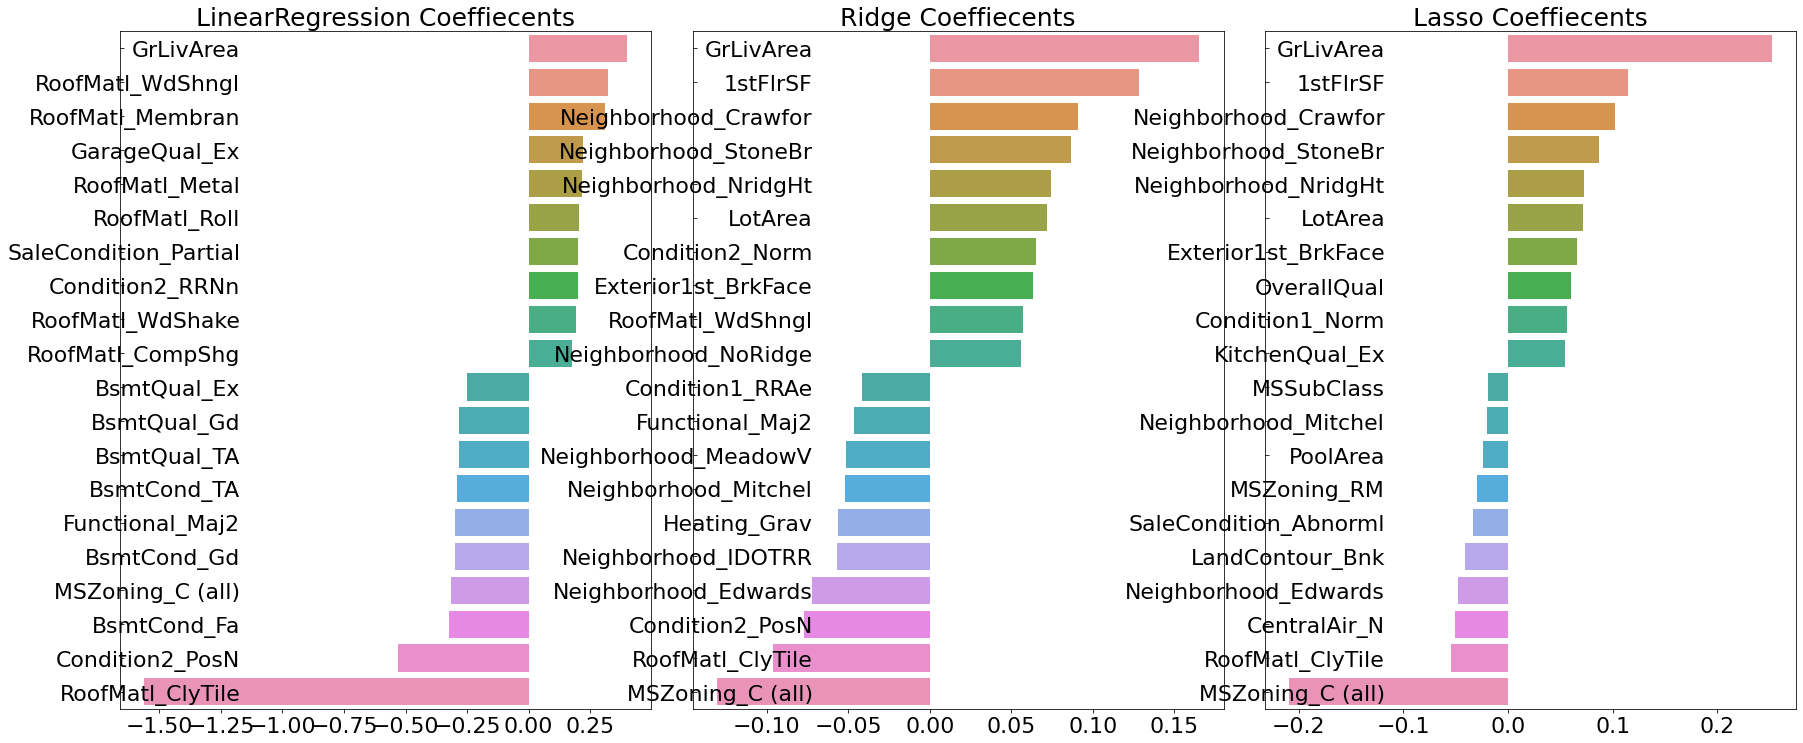

In [67]:
# 위 하이퍼 파라미터 튜닝 결과를 이용해 재 학습 및 회귀계수 시각화

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

최종적으로 세 모델 모두 GrLivArea 라는 주거 공간 피처의 회귀 계수가 가장 높게 나타났으며 이는 주거 공간의 크기가 주택 가격에 가장 많은 영향을 미친다는 것으로 상식선의 결과가 도출

이어서 회귀 계수가 높은 피처의 이상치 데이터 처리를 위해 GrLivArea 피처의 데이터 분포를 확인

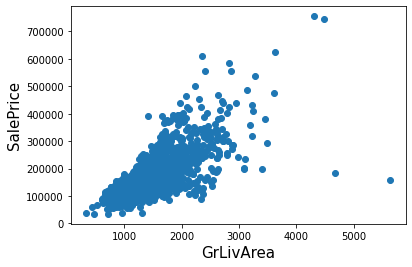

In [71]:
plt.scatter(x = house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

위 시각화 결과 주택가격과 주거공간의크기는 선형적인 관계를 갖지만 일부 데이터의 경우 아웃라이어로 판단

In [75]:
# GrLivArea와 SalePrice 모두 로그 변환되어 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)

outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :', ourlier_index.values)
print('이상치 삭제 전 house_df_ohe_shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe_shape:', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe_shape: (1460, 271)
이상치 삭제 후 house_df_ohe_shape: (1458, 271)


업데이트 된 house_df_ohe 를 기반으로 다시 피처, 타겟 데이터 셋을 생성하고 모델 최적화를 수행해 결과를 출력

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha : {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha : {'alpha': 0.001}

LinearRegression CV RMSE 값 리스트 : [0.115 0.128 0.142 0.113 0.118]
LinearRegression CV 평균 RMSE 값 : 0.123

Ridge CV RMSE 값 리스트 : [0.103 0.118 0.122 0.104 0.114]
Ridge CV 평균 RMSE 값 : 0.112

Lasso CV RMSE 값 리스트 : [0.103 0.117 0.122 0.106 0.112]
Lasso CV 평균 RMSE 값 : 0.112


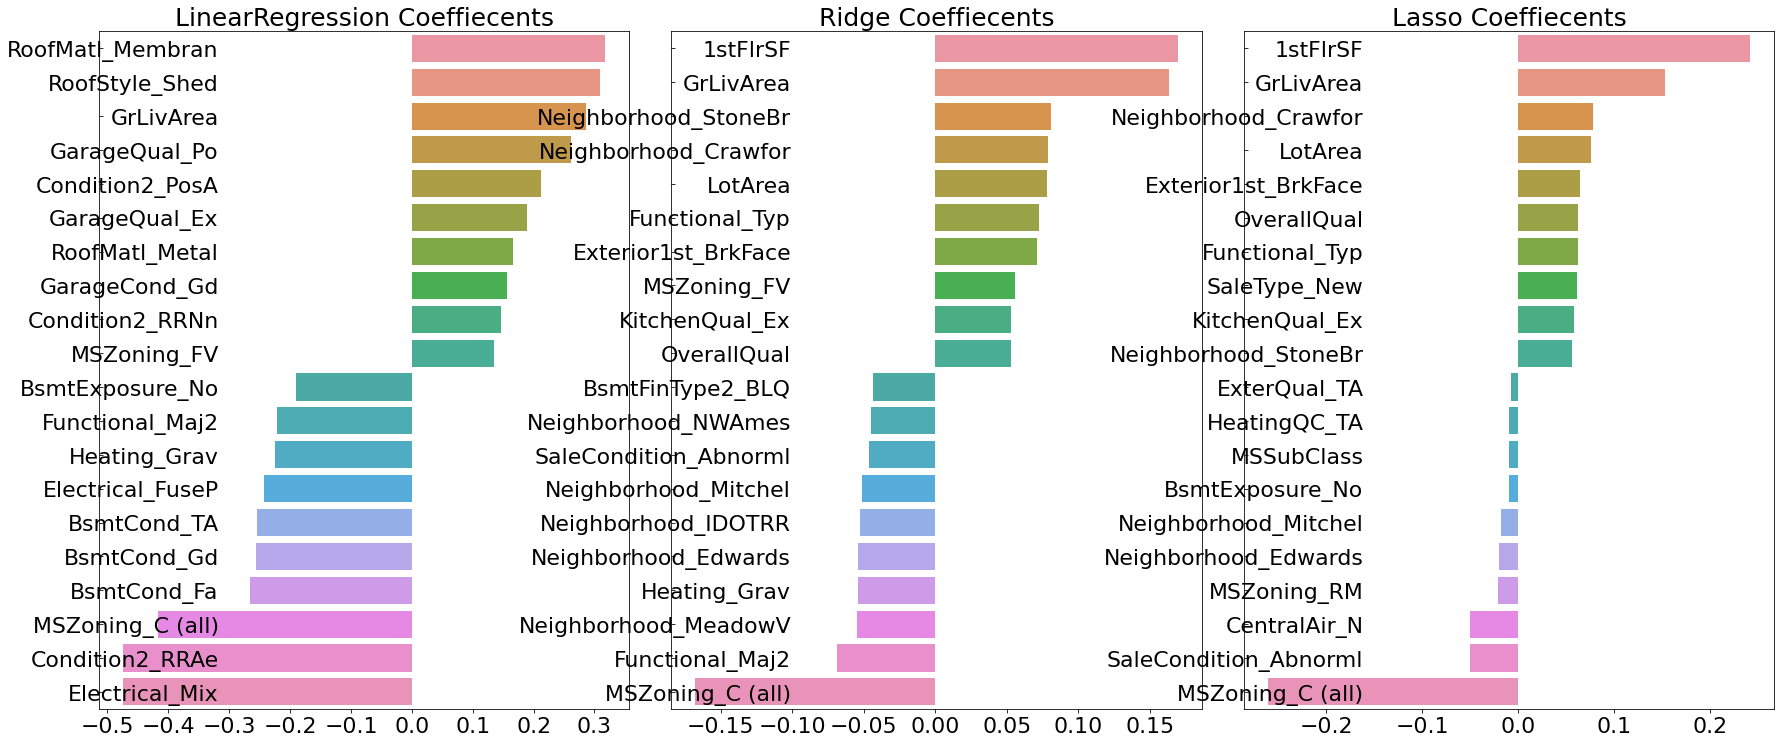

In [86]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

# 위 하이퍼 파라미터 튜닝 결과를 이용해 재 학습 및 회귀계수 시각화

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)
get_avg_rmse_cv(models)

단 두개의 이상치 데이터를 제거한 결과 예측 성능이 매우 크게 향상됨.

# 회귀 트리 모델 학습/예측/평가
---

이어서 XGBoost, LIghtGBM 모델로 예측을 진행

In [81]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators' : [1000]}
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1178, 최적 alpha : {'n_estimators': 1000}


In [84]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators' : [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate = 0.05, num_leaves=4,
                        subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=1)

print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1163, 최적 alpha : {'n_estimators': 1000}


In [100]:
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.4, learning_rate=0.05, n_estimators=1000,
              n_jobs=1, num_leaves=4, reg_lambda=10, subsample=0.6)

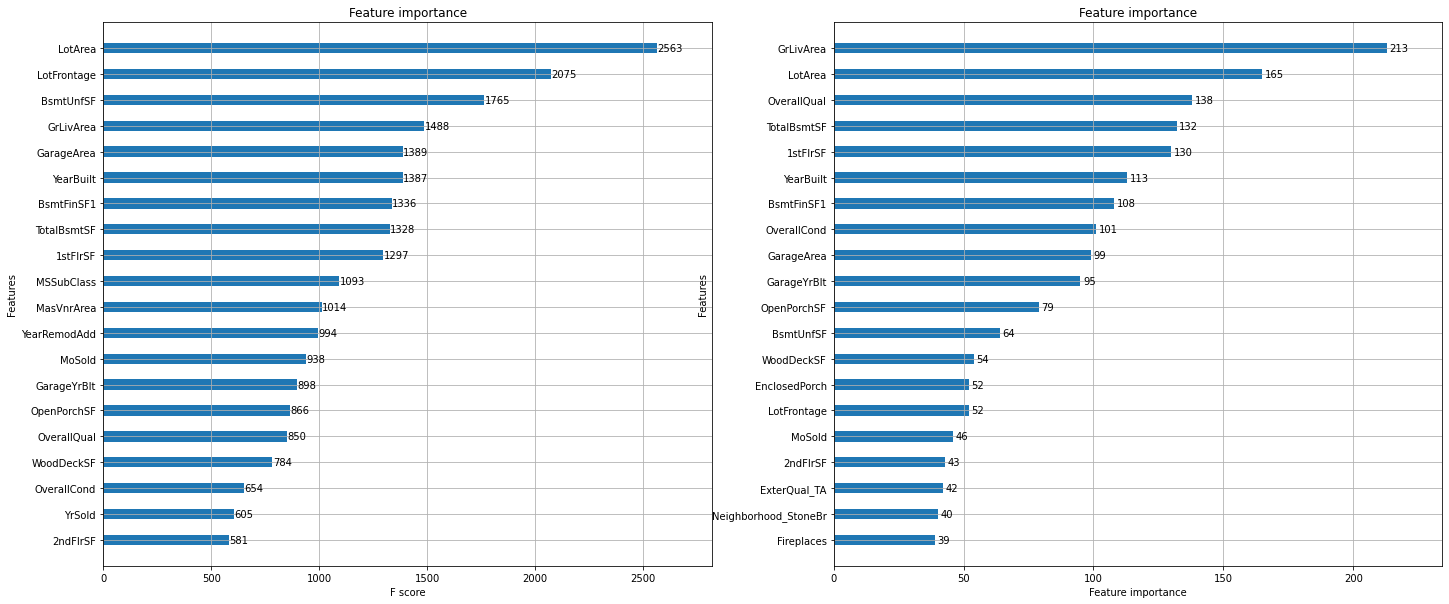

In [147]:
# plot_importance() 를 이용한 피처 즁요도 시각화
# 좌 XGB, 우 LGBM

fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=2)
axs[0].set_title(xgb_reg.__class__.__name__+' Feature Importances', size=30)
axs[1].set_title(lgbm_reg.__class__.__name__+' Feature Importances', size=30)
from xgboost import plot_importance
plot_importance(xgb_reg, max_num_features = 20, ax=axs[0], height=0.4)

from lightgbm import plot_importance
plot_importance(lgbm_reg, max_num_features = 20, ax=axs[1], height=0.4)
plt.show()

# 예측 결과 혼합을 통한 최종 예측
---

개별 회귀 모델 예측 결과값을 혼합해 최종 회귀 값을 예측

In [152]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{} 모델의 RMSE : {}'.format(key, rmse))
        
# 개별 모델 학습
ridge_reg = Ridge(alpha=0.8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred

preds = {'최종 혼합': pred,
        'Ridge': ridge_pred,
        'Lasso': lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10123104084844885
Ridge 모델의 RMSE : 0.11290736875948866
Lasso 모델의 RMSE : 0.10024170460890024


이번에는 XGB와 LGBM을 혼합

In [155]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred

preds = {'최종 혼합': pred,
        'XGBM': xgb_pred,
        'LGBM': lgbm_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10170077353447762
XGBM 모델의 RMSE : 0.10738295638346222
LGBM 모델의 RMSE : 0.10382510019327311


# 스태킹 앙상블 모델을 통한 회귀 예측
---

In [156]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    
    # 추후 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__,' model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ',folder_counter+1,' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어지 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용, DF를 넘파이로 변환

X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반 (BASE) 모델이 생성한 학습용/테스트용 데이터 변환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
Lasso  model 시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
XGBRegressor  model 시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
LGBMRegressor  model 시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작


In [157]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합

Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델 적용
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print("스태킹 회귀 모델의 최종 RMSE : ",rmse)

스태킹 회귀 모델의 최종 RMSE :  0.09800972108427672
